In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import glob
import os
import metpy
import numpy as np
from datetime import datetime
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
from metpy.calc import dewpoint_from_relative_humidity
from metpy.calc import specific_humidity_from_dewpoint
from pint import UnitRegistry
ureg = UnitRegistry()
from scipy.stats import sem, t
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import ttest_ind


In [2]:
# Define file paths
file1 = "C:\\YEAR1\\NMVOC\\Data\\data_Meteo\\processed_met_11_23.csv"
file2 = "C:\\YEAR1\\NMVOC\\Data\\processed_c3h8.csv"
file3 = "C:\\YEAR1\\NMVOC\\Data\\processed_CH4.csv"
file4 = "C:\\YEAR1\\NMVOC\\Data\\processed_CO.csv"
file5 = "C:\\YEAR1\\NMVOC\\Data\\processed_O3.csv"

# Read meteo data, parse 'DATETIME' as datetime, and set as index
df1 = pd.read_csv(file1, parse_dates=['DATETIME'])
df1 = df1.set_index('DATETIME')
df1 = df1.reset_index().rename(columns={'DATETIME': 'datetime'})  # ensure column is named 'datetime'

# Read C3H8, CO, CH4, =3 data, parse 'datetime' as datetime
df2 = pd.read_csv(file2, parse_dates=['datetime'])

df3 = pd.read_csv(file3 , parse_dates=['datetime'])
df4 = pd.read_csv(file4, parse_dates=['datetime'])
df5 = pd.read_csv(file5, parse_dates=['datetime'])


# Merge all datasets on 'datetime' using an inner join
merged_df = df1.merge(df2, on='datetime', how='inner') \
               .merge(df3, on='datetime', how='inner') \
               .merge(df4, on='datetime', how='inner') \
                .merge(df5, on='datetime', how='inner')

# Display result
print(merged_df)

                 datetime  wind_speed  temperature  relative_humidity  \
0     2011-06-17 11:00:00       11.45        11.10              78.70   
1     2011-06-17 13:00:00        9.70         9.20              98.30   
2     2011-06-17 17:00:00       13.10         8.55              98.25   
3     2011-06-17 23:00:00       20.75         8.20              80.65   
4     2011-06-18 01:00:00       20.60         8.05              84.20   
...                   ...         ...          ...                ...   
23572 2023-12-30 17:00:00        2.86         4.42              99.00   
23573 2023-12-30 19:00:00        2.85         4.58              74.00   
23574 2023-12-30 20:00:00        2.67         3.65              87.00   
23575 2023-12-30 22:00:00        2.54         2.81              98.00   
23576 2023-12-30 23:00:00        2.95         2.98              94.00   

       pressure  C3H8_ppb  CH4_ppb    CO_ppb  O3_ppb  
0        794.55   0.14212  1844.85   93.1660    50.5  
1        794.

In [3]:
# Convert 'DATETIME' column to datetime if not already
merged_df["datetime"] = pd.to_datetime(merged_df["datetime"])
# helper columns with  hour, month, year
merged_df['hour'] = merged_df['datetime'].dt.hour
merged_df['month'] = merged_df['datetime'].dt.month
merged_df['year'] = merged_df['datetime'].dt.year
merged_df['date'] = merged_df['datetime'].dt.date
merged_df['month-day'] = merged_df['datetime'].dt.strftime('%m-%d')

In [4]:
# Ensure 'date' is datetime
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Add season (DJF, MAM, JJA, SON)

# Define season function
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

merged_df['season'] = merged_df['month'].apply(get_season)

   Degree        R2       MSE
0       1  0.000321  0.060012
1       2  0.001146  0.059962
2       3  0.002222  0.059898
3       4  0.011770  0.059324
4       5  0.010604  0.059394


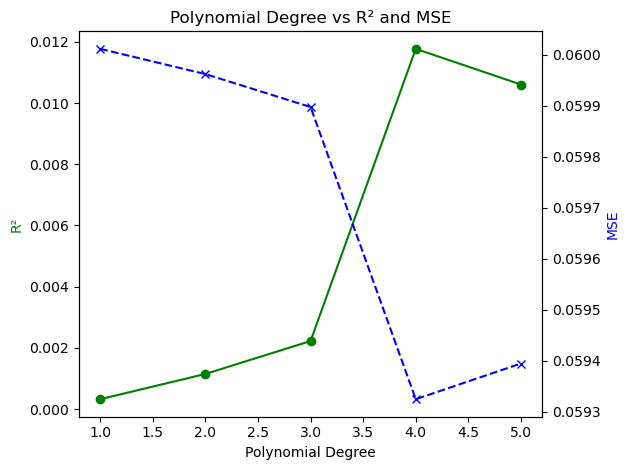

In [5]:

#Find Best Polynomial Degree

# Assume df has datetime index and 'C3H8_ppb' column
merged_df = merged_df.sort_index().copy()
merged_df['time'] = np.arange(len(merged_df))  # time in hours

# Define range of polynomial degrees to test
degrees = range(1, 6)
results = []

for deg in degrees:
    poly = PolynomialFeatures(degree=deg)
    X_poly = poly.fit_transform(merged_df[['time']])
    model = LinearRegression().fit(X_poly, merged_df['C3H8_ppb'])
    y_pred = model.predict(X_poly)
    
    r2 = r2_score(merged_df['C3H8_ppb'], y_pred)
    mse = mean_squared_error(merged_df['C3H8_ppb'], y_pred)
    results.append((deg, r2, mse))

# Convert to DataFrame
results_df = pd.DataFrame(results, columns=['Degree', 'R2', 'MSE'])

# Display results
print(results_df)

# Plot R2 and MSE vs Degree
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(results_df['Degree'], results_df['R2'], 'g-', marker='o', label='R²')
ax2.plot(results_df['Degree'], results_df['MSE'], 'b--', marker='x', label='MSE')

ax1.set_xlabel('Polynomial Degree')
ax1.set_ylabel('R²', color='g')
ax2.set_ylabel('MSE', color='b')
plt.title("Polynomial Degree vs R² and MSE")
plt.tight_layout()
plt.show()


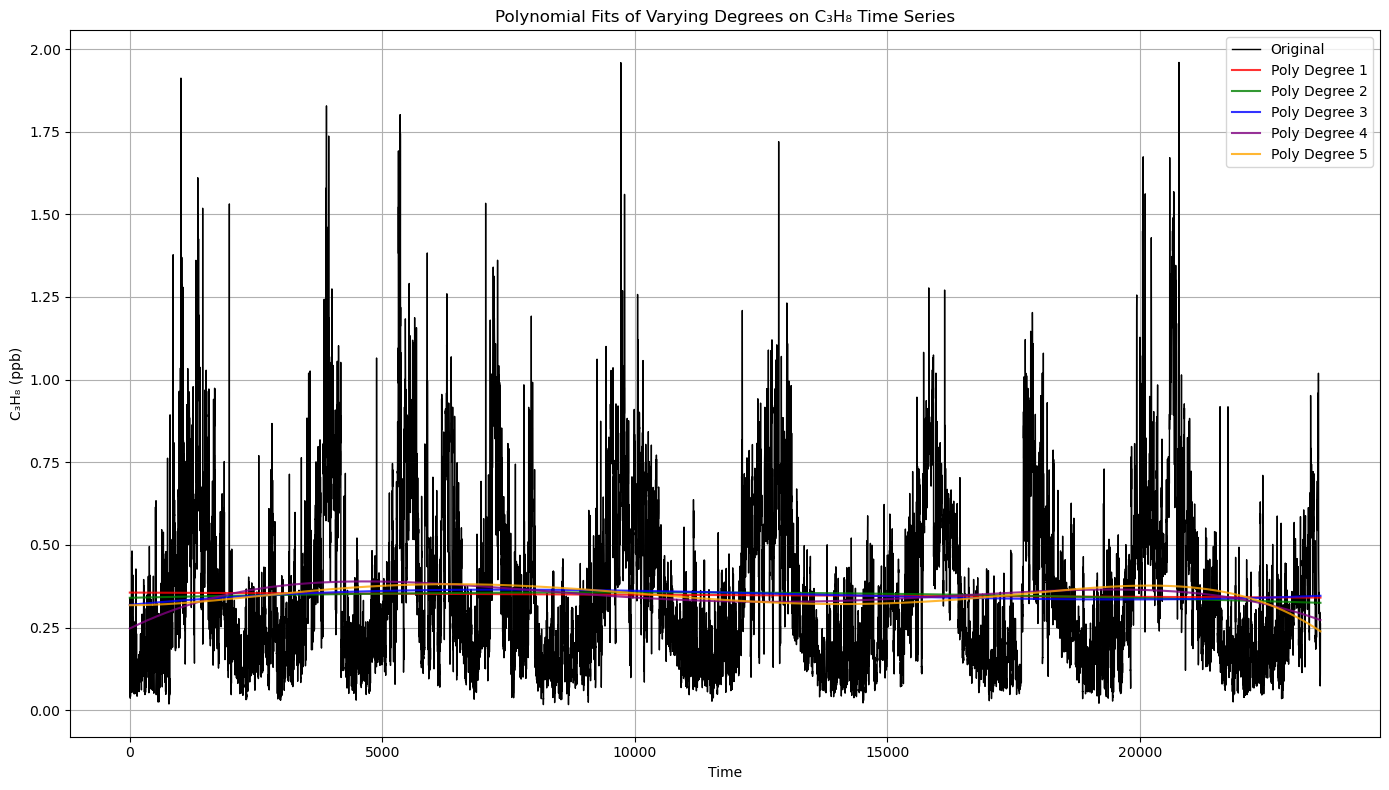

In [6]:

# Assume df has datetime index and 'C3H8_ppb' column
merged_df = merged_df.sort_index().copy()
merged_df['time'] = np.arange(len(merged_df))  # Numeric time for regression

# Degrees to compare
degrees = [1, 2, 3, 4, 5]

plt.figure(figsize=(14, 8))
plt.plot(merged_df.index, merged_df['C3H8_ppb'], label='Original', color='black', linewidth=1)

# Plot each polynomial fit
colors = ['red', 'green', 'blue', 'purple', 'orange']

for i, deg in enumerate(degrees):
    poly = PolynomialFeatures(degree=deg)
    X_poly = poly.fit_transform(merged_df[['time']])
    model = LinearRegression().fit(X_poly, merged_df['C3H8_ppb'])
    y_pred = model.predict(X_poly)
    
    plt.plot(merged_df.index, y_pred, label=f'Poly Degree {deg}', color=colors[i], alpha=0.8)

plt.title("Polynomial Fits of Varying Degrees on C₃H₈ Time Series")
plt.xlabel("Time")
plt.ylabel("C₃H₈ (ppb)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#Removes a polynomial trend
# Retains the seasonal cycle modeled using harmonic terms (sine and cosine) over a 1-year period (8760 hours)
# 1. Assume df has 'datetime' index and 'C3H8_ppb' column
merged_df = merged_df.sort_index().copy()
merged_df['time'] = np.arange(len(merged_df))  # numeric time in hours

# 2. Polynomial trend fit (e.g., 3rd order)
poly_deg = 3
poly = PolynomialFeatures(poly_deg)
X_poly = poly.fit_transform(merged_df[['time']])
poly_model = LinearRegression().fit(X_poly, merged_df['C3H8_ppb'])
merged_df['poly_trend'] = poly_model.predict(X_poly)

# 3. Remove polynomial trend
merged_df['detrended'] = merged_df['C3H8_ppb'] - merged_df['poly_trend']

# 4. Add harmonic terms for seasonal cycle (hourly scale)
T1 = 8760  # Annual cycle in hours
T2 = 4380  # Semi-annual cycle

omega1 = 2 * np.pi / T1
omega2 = 2 * np.pi / T2

merged_df['sin1'] = np.sin(omega1 * merged_df['time'])
merged_df['cos1'] = np.cos(omega1 * merged_df['time'])
merged_df['sin2'] = np.sin(omega2 * merged_df['time'])
merged_df['cos2'] = np.cos(omega2 * merged_df['time'])

# 5. Harmonic model fit (on detrended data)
harmonic_model = LinearRegression().fit(
    merged_df[['sin1', 'cos1', 'sin2', 'cos2']],
    merged_df['detrended']
)
merged_df['harmonic_component'] = harmonic_model.predict(merged_df[['sin1', 'cos1', 'sin2', 'cos2']])

# 6. Optional: final cleaned signal = seasonal only or detrended without seasonal
merged_df['seasonal_only'] = merged_df['harmonic_component']
merged_df['residual'] = merged_df['detrended'] - merged_df['harmonic_component']  # completely deseasonalized & detrended

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(merged_df.index, merged_df['C3H8_ppb'], label='Original', alpha=0.5)
plt.plot(merged_df.index, merged_df['poly_trend'], label='Polynomial Trend', linestyle='--')
plt.plot(merged_df.index, merged_df['seasonal_only'], label='Seasonal (Harmonic)', color='orange', alpha=0.8)
plt.plot(merged_df.index, merged_df['residual'], label='Residual (Deseasonalized + Detrended)', alpha=0.7)
plt.legend()
plt.title("C₃H₈ Detrended Time Series (Hourly Data)")
plt.ylabel("C₃H₈ (ppb)")
plt.xlabel("Time")
plt.tight_layout()
plt.show()


NameError: name 'df' is not defined

In [8]:
#dewpoint from T and RH
dewpoint=dewpoint_from_relative_humidity(merged_df["temperature"].values*units.degC, merged_df["relative_humidity"].values*units.percent)
dewpoint

Magnitude,[7.5418557443974805 8.945782941258358 8.28959154022283 ... 1.688635661366959 2.5254646943712373 2.109418902229777]
Units,degree_Celsius


In [9]:
#Specific humidity from temperature and dewpoint
SH=specific_humidity_from_dewpoint(merged_df["pressure"].values*units.hPa, dewpoint).to('g/kg')
merged_df ["SH"] = SH
merged_df

,datetime,wind_speed,temperature,relative_humidity,pressure,C3H8_ppb,CH4_ppb,CO_ppb,O3_ppb,hour,...,month-day,season,time,poly_trend,detrended,sin1,cos1,sin2,cos2,SH
0,2011-06-17 11:00:00,11.45,11.10,78.70,794.55,0.14212,1844.85,93.1660,50.5,11,...,06-17,Summer,0,0.318740,-0.176620,0.000000,1.000000,0.000000,1.000000,8.175584
1,2011-06-17 13:00:00,9.70,9.20,98.30,794.45,0.15840,1856.25,102.3575,57.1,13,...,06-17,Summer,1,0.318754,-0.160354,0.000717,1.000000,0.001435,0.999999,8.998805
2,2011-06-17 17:00:00,13.10,8.55,98.25,793.05,0.08721,1835.98,93.6670,54.6,17,...,06-17,Summer,2,0.318768,-0.231558,0.001435,0.999999,0.002869,0.999996,8.621069
3,2011-06-17 23:00:00,20.75,8.20,80.65,791.85,0.05857,1839.14,90.8355,54.9,23,...,06-17,Summer,3,0.318782,-0.260212,0.002152,0.999998,0.004304,0.999991,6.914058
4,2011-06-18 01:00:00,20.60,8.05,84.20,791.30,0.06136,1839.20,92.8540,57.0,1,...,06-18,Summer,4,0.318796,-0.257436,0.002869,0.999996,0.005738,0.999984,7.151183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23572,2023-12-30 17:00:00,2.86,4.42,99.00,795.71,0.07839,1992.76,122.0020,39.0,17,...,12-30,Winter,23572,0.346032,-0.267642,-0.931769,-0.363051,0.676559,-0.736388,6.506577
23573,2023-12-30 19:00:00,2.85,4.58,74.00,795.63,0.09994,1988.35,117.0450,42.1,19,...,12-30,Winter,23573,0.346038,-0.246098,-0.932030,-0.362382,0.675502,-0.737358,4.913997
23574,2023-12-30 20:00:00,2.67,3.65,87.00,795.48,0.11000,1984.59,114.0310,42.3,20,...,12-30,Winter,23574,0.346044,-0.236044,-0.932289,-0.361714,0.674444,-0.738326,5.414930
23575,2023-12-30 22:00:00,2.54,2.81,98.00,796.01,0.24459,1981.67,113.9700,42.2,22,...,12-30,Winter,23575,0.346050,-0.101460,-0.932548,-0.361045,0.673384,-0.739293,5.745303


In [ ]:
merged_df.index = merged_df.datetime
merged_df.year.plot()

AttributeError: 'DataFrame' object has no attribute 'DATETIME'

In [11]:


# Filter data from 2015 to 2019
df_15_19 = df[(df["year"] >= 2015) & (df["year"] <= 2019)]

df_15_19


NameError: name 'df' is not defined

In [13]:
# Compute 25th and 75th percentiles for SH and WS over the whole dataset
sh_25, sh_75 = merged_df["SH"].quantile(0.25), merged_df["SH"].quantile(0.75)
ws_25, ws_75 = merged_df["wind_speed"].quantile(0.25), merged_df["wind_speed"].quantile(0.75)

# Assign computed quantiles as new columns
merged_df["SH_25"], merged_df["SH_75"] = sh_25, sh_75
merged_df["WS_25"], merged_df["WS_75"] = ws_25, ws_75

df_percentile=merged_df
# Print  rows to check
print(df_percentile.tail())


                 datetime  wind_speed  temperature  relative_humidity  \
23572 2023-12-30 17:00:00        2.86         4.42               99.0   
23573 2023-12-30 19:00:00        2.85         4.58               74.0   
23574 2023-12-30 20:00:00        2.67         3.65               87.0   
23575 2023-12-30 22:00:00        2.54         2.81               98.0   
23576 2023-12-30 23:00:00        2.95         2.98               94.0   

       pressure  C3H8_ppb  CH4_ppb   CO_ppb  O3_ppb  hour  ...  detrended  \
23572    795.71   0.07839  1992.76  122.002    39.0    17  ...  -0.267642   
23573    795.63   0.09994  1988.35  117.045    42.1    19  ...  -0.246098   
23574    795.48   0.11000  1984.59  114.031    42.3    20  ...  -0.236044   
23575    796.01   0.24459  1981.67  113.970    42.2    22  ...  -0.101460   
23576    796.26   0.26068  1980.46  112.503    42.4    23  ...  -0.085376   

           sin1      cos1      sin2      cos2        SH     SH_25     SH_75  \
23572 -0.931769 -0.

In [ ]:
df_15_19.temperature.plot()

In [14]:


# Apply conditions to classify data
def classify(row):
    if row["SH"] < row["SH_25"] and row["wind_speed"] > row["WS_25"]:
        return "FT"
    elif row["SH"] > row["SH_75"] and row["wind_speed"] < row["WS_25"]:
        return "PBL"
    else:
        return "Other"

df_percentile["Label"] = df_percentile.apply(classify, axis=1)



In [15]:
monthly_stats = df_percentile.groupby(["month"])["Label"].describe()
monthly_stats

,count,unique,top,freq
month,,,,
1,1807,2,FT,1117
2,1282,2,Other,712
3,1307,2,Other,813
4,1898,2,Other,1493
5,2043,3,Other,1880
6,2607,3,Other,2134
7,2411,3,Other,1813
8,1883,3,Other,1423
9,1696,3,Other,1411


In [ ]:
# Count occurrences of each label per month
#monthly_counts = df_percentile.groupby(["month"])["Label"].value_counts().unstack(fill_value=0)
#monthly_total = monthly_counts.sum(axis=1)
#entry_count = df_percentile["Label"].count()
# Convert FT and PBL counts to percentages
#monthly_percentage = (monthly_counts.div(entry_count, axis=0)) * 100

In [16]:
# Count occurrences of each label per month
monthly_counts = df_percentile.groupby(["month"])["Label"].value_counts().unstack(fill_value=0)
# Count occurrences of 'pbl' and 'ft'
count_pbl = (df_percentile["Label"] == 'PBL').sum()
count_ft = (df_percentile["Label"] == 'FT').sum()

print(f"Count of 'pbl': {count_pbl}")
print(f"Count of 'ft': {count_ft}")
count_ft_pbl= count_ft + count_pbl
monthly_percentage = (monthly_counts.div(count_ft_pbl, axis=0)) * 100

Count of 'pbl': 1817
Count of 'ft': 4664


In [ ]:
monthly_counts

In [ ]:
monthly_percentage

In [ ]:
#ft_count = (df_percentile["Label"] == 'FT').sum()
#ft_perc=(ft_count /entry_count )*100
#print(ft_perc)


In [17]:
ft_count = (df_percentile["Label"] == 'FT').sum()
ft_perc=(ft_count /count_ft_pbl )*100
print(ft_perc)

71.9642030550841


In [ ]:
#pbl_count = (df_percentile["Label"] == 'PBL').sum()
#pbl_perc=(pbl_count /entry_count )*100
#print(pbl_perc)


In [18]:
pbl_count = (df_percentile["Label"] == 'PBL').sum()
pbl_perc=(pbl_count /count_ft_pbl)*100
print(pbl_perc)


28.03579694491591


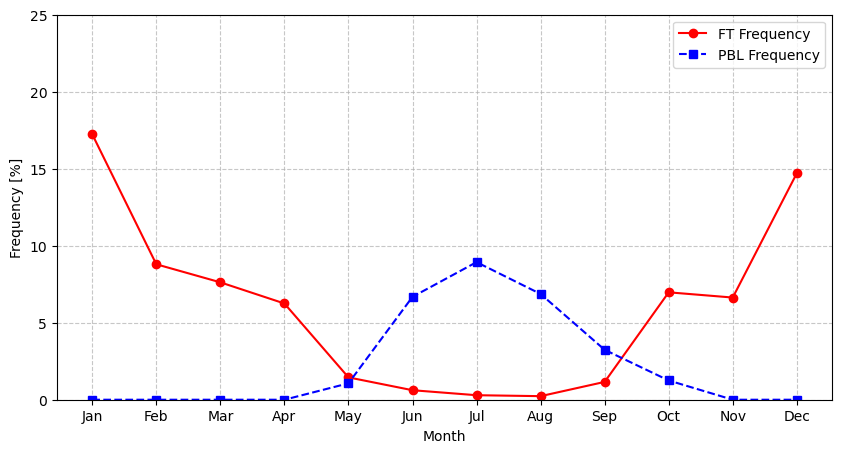

In [19]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(monthly_percentage.index, monthly_percentage["FT"], marker="o", linestyle="-", label="FT Frequency", color="red")
plt.plot(monthly_percentage.index, monthly_percentage["PBL"], marker="s", linestyle="--", label="PBL Frequency", color="blue")

# Formatting the plot
plt.xlabel("Month")
plt.ylabel("Frequency [%]")
#plt.title("Monthly Frequency of FT and PBL Observations (2011-2023)")
plt.xticks(ticks=range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.ylim(0,25)
plt.savefig("C:\\YEAR1\\NMVOC\\figures\\meteo_FT_PBL_11_23.png", dpi=300)

# Show plot
plt.show()


In [20]:

# Define date ranges
date_ranges = {
    "03-09 to 05-04": ("03-09", "05-04"),
    "05-05 to 10-22": ("05-05", "10-22"),
    "10-23 to 12-29": ("10-23", "12-29"),
}

In [21]:



results = []

# Loop by Label and date range
for label in merged_df['Label'].unique():
    for range_name, (start_md, end_md) in date_ranges.items():
        # Filter current label and date range
        mask = (merged_df['month-day'] >= start_md) & (merged_df['month-day'] <= end_md)
        subset = merged_df[mask & (merged_df['Label'] == label)]

        # Mean C3H8_ppb for each period
        mean_2020 = subset[subset['year'] == 2020]['C3H8_ppb'].mean()
        mean_2017_2019 = subset[subset['year'].isin([2017, 2018, 2019])]['C3H8_ppb'].mean()
        mean_2021_2023 = subset[subset['year'].isin([2021, 2022, 2023])]['C3H8_ppb'].mean()

        # Differences
        diff_2020_2017_2019 = mean_2020 - mean_2017_2019
        diff_2020_2021_2023 = mean_2020 - mean_2021_2023

        # Append results
        results.append({
            'Label': label,
            'Date Range': range_name,
            '2020 Mean': mean_2020,
            '2017–2019 Mean': mean_2017_2019,
            '2021–2023 Mean': mean_2021_2023,
            'Diff (2020 - 2017–2019)': diff_2020_2017_2019,
            'Diff (2020 - 2021–2023)': diff_2020_2021_2023
        })

# Create DataFrame
diff_df = pd.DataFrame(results)
print(diff_df)
#diff_df.to_csv("C:\\YEAR1\\NMVOC\\figures\\Covid_FT_PBL.csv",sep="\t")



   Label      Date Range  2020 Mean  2017–2019 Mean  2021–2023 Mean  \
0  Other  03-09 to 05-04   0.432250        0.437091        0.466192   
1  Other  05-05 to 10-22   0.193892        0.187947        0.194466   
2  Other  10-23 to 12-29   0.357809        0.463658        0.414538   
3     FT  03-09 to 05-04   0.557822        0.465755        0.522117   
4     FT  05-05 to 10-22   0.217368        0.263178        0.192208   
5     FT  10-23 to 12-29   0.483747        0.537085        0.469482   
6    PBL  03-09 to 05-04        NaN             NaN             NaN   
7    PBL  05-05 to 10-22   0.168980        0.192276        0.198251   
8    PBL  10-23 to 12-29        NaN        0.113560             NaN   

   Diff (2020 - 2017–2019)  Diff (2020 - 2021–2023)  
0                -0.004841                -0.033942  
1                 0.005945                -0.000574  
2                -0.105849                -0.056729  
3                 0.092067                 0.035705  
4                -0

In [22]:
#To calculate whether the differences in C3H8_ppb means in 2020 vs. 2017–2019 and 2021–2023 
# are statistically significant at the 95% confidence level (p < 0.05
 #Welch's t-test (scipy.stats.ttest_ind



results = []

# Loop through each label and date range
for label in merged_df['Label'].unique():
    for range_name, (start_md, end_md) in date_ranges.items():
        # Filter by label and date range
        mask = (merged_df['Label'] == label) & (merged_df['month-day'] >= start_md) & (merged_df['month-day'] <= end_md)
        subset = merged_df[mask]

        # Get groups
        c3h8_2020 = subset[subset['year'] == 2020]['C3H8_ppb']
        c3h8_2017_2019 = subset[subset['year'].isin([2017, 2018, 2019])]['C3H8_ppb']
        c3h8_2021_2023 = subset[subset['year'].isin([2021, 2022, 2023])]['C3H8_ppb']

        # Means
        mean_2020 = c3h8_2020.mean()
        mean_17_19 = c3h8_2017_2019.mean()
        mean_21_23 = c3h8_2021_2023.mean()

        # T-tests (Welch's)
        t_stat1, pval1 = stats.ttest_ind(c3h8_2020, c3h8_2017_2019, equal_var=False, nan_policy='omit')
        t_stat2, pval2 = stats.ttest_ind(c3h8_2020, c3h8_2021_2023, equal_var=False, nan_policy='omit')

        results.append({
            'Label': label,
            'Date Range': range_name,
            '2020 Mean': mean_2020,
            '2017–2019 Mean': mean_17_19,
            '2021–2023 Mean': mean_21_23,
            'p-value (2020 vs 2017–2019)': pval1,
            'Significant (p<0.05)': pval1 < 0.05,
            'p-value (2020 vs 2021–2023)': pval2,
            'Significant (p<0.05)': pval2 < 0.05,
        })

# Create DataFrame
Covid_df = pd.DataFrame(results)
print(Covid_df)
Covid_df.to_csv("C:\\YEAR1\\NMVOC\\figures\\Covid_FT_PBL.csv",sep="\t")


   Label      Date Range  2020 Mean  2017–2019 Mean  2021–2023 Mean  \
0  Other  03-09 to 05-04   0.432250        0.437091        0.466192   
1  Other  05-05 to 10-22   0.193892        0.187947        0.194466   
2  Other  10-23 to 12-29   0.357809        0.463658        0.414538   
3     FT  03-09 to 05-04   0.557822        0.465755        0.522117   
4     FT  05-05 to 10-22   0.217368        0.263178        0.192208   
5     FT  10-23 to 12-29   0.483747        0.537085        0.469482   
6    PBL  03-09 to 05-04        NaN             NaN             NaN   
7    PBL  05-05 to 10-22   0.168980        0.192276        0.198251   
8    PBL  10-23 to 12-29        NaN        0.113560             NaN   

   p-value (2020 vs 2017–2019)  Significant (p<0.05)  \
0                 7.237515e-01                  True   
1                 6.647009e-02                 False   
2                 3.902624e-17                  True   
3                 1.793213e-04                 False   
4        